In [1]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset, split_train_val, prepare_test_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained, upload_pretrained_vit, upload_pretrained_densenet121
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.models as models
import pickle
import lime


### Pre-processing

In [2]:
class_names = ['Pleural Effusion']
policies = ['ones', 'zeroes', 'mixed']
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


# Import the validation dataset as final test set
test_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Prepare the test dataset using the last policy in the list and the defined class names
test_image_paths, test_label_matrix = prepare_dataset(test_df, policies[-1], class_names)

# Create a DataFrame for the test image paths
test_image_paths_df = pd.DataFrame({'path': test_image_paths})

# Create a DataFrame for the test labels with the class names as columns
test_labels_df = pd.DataFrame(test_label_matrix, columns=class_names)

# Combine the test image paths DataFrame and the test labels DataFrame
test_df = pd.concat([test_image_paths_df, test_labels_df], axis=1)


In [3]:
test_df.iloc[1]

path                CheXpert-v1.0-small/valid/patient64634/study1/...
Pleural Effusion                                                    0
Name: 1, dtype: object

#### Uploading the model we trained

In [4]:
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model_densenet121 = upload_pretrained_densenet121(densenet121, add_layers=True, n_labels=len(class_names), freeze_layers=True)
state_dict = torch.load("model_densenet121.pth", map_location=torch.device('cpu'))



#### DataLoader object

In [8]:
test_dataset = CheXpertDataset(test_df, class_names, transform=transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Evaluation of the model

In [6]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    # model.to(device)
    # model.eval()  # Set the model to evaluation mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)
            
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert pre`dictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels

In [7]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model_densenet121, test_loader, criterion)

Evaluating: 100%|██████████| 13/13 [00:23<00:00,  1.83s/batch]

Test Loss: 0.7374, Test Accuracy: 0.3218


In [9]:
# Load a test image from testloader
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0]  # Select the first image
true_label = labels[0].item()


img.shape

torch.Size([3, 224, 224])

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[0.4449, 0.5551],
        [0.4338, 0.5662],
        [0.4299, 0.5701],
        [0.4505, 0.5495],
        [0.4378, 0.5622],
        [0.4325, 0.5675],
        [0.4402, 0.5598],
        [0.4366, 0.5634],
        [0.4442, 0.5558],
        [0.4295, 0.5705]])
tensor([[0.4288, 0.5712],
        [0.4431, 0.5569],
        [0.4307, 0.5693],
        [0.4304, 0.5696],
        [0.4397, 0.5603],
        [0.4354, 0.5646],
        [0.4404, 0.5596],
        [0.4408, 0.5592],
        [0.4355, 0.5645],
        [0.4339, 0.5661]])
tensor([[0.4381, 0.5619],
        [0.4137, 0.5863],
        [0.4453, 0.5547],
        [0.4263, 0.5737],
        [0.4197, 0.5803],
        [0.4339, 0.5661],
        [0.4465, 0.5535],
        [0.4190, 0.5810],
        [0.4549, 0.5451],
        [0.4426, 0.5574]])
tensor([[0.4301, 0.5699],
        [0.4453, 0.5547],
        [0.4406, 0.5594],
        [0.4329, 0.5671],
        [0.4540, 0.5460],
        [0.4337, 0.5663],
        [0.4279, 0.5721],
        [0.4349, 0.5651],
        [

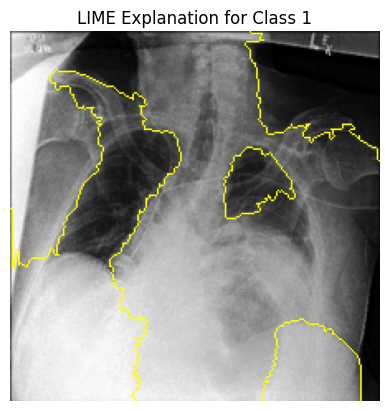

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from PIL import Image

# Ensure your model is in evaluation mode and on the proper device.
model_densenet121.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet121.to(device)

# Helper: convert a PyTorch image tensor to a NumPy array normalized to [0,1]
def preprocess_img(img_tensor):
    # Unnormalize the image: original = normalized * std + mean
    # Since mean=0.5 and std=0.5 for grayscale images:
    unnormalized = img_tensor * 0.5 + 0.5  
    # Convert tensor from (C, H, W) to (H, W, C)
    img_np = unnormalized.permute(1, 2, 0).cpu().numpy()
    return img_np

# Assuming you have obtained an image from your testloader:
# For example, grabbing the first image from a batch:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[1]  # select the first image from the batch
img_np = preprocess_img(img)

# Prediction function for LIME:
def predict_fn(images):
    """
    images: list/array of images in NumPy format (H x W x C), with pixel values in [0, 1].
    Returns: a NumPy array of shape (n_samples, 2) with class probabilities.
    """
    # Convert each LIME image (numpy array) to a PIL image, then to a tensor.
    tensor_images = [
        transforms.ToTensor()(Image.fromarray((img * 255).astype(np.uint8)))
        for img in images
    ]
    # Stack into a single batch tensor of shape (N, C, H, W)
    batch = torch.stack(tensor_images).to(device)
    
    with torch.no_grad():
        outputs = model_densenet121(batch)  # outputs shape: (batch, 1)
        # Apply sigmoid to get probability for class 1.
        probs_class1 = torch.sigmoid(outputs)
        # Create two-class probabilities: class0 = 1 - p, class1 = p.
        probs = torch.cat([1 - probs_class1, probs_class1], dim=1)
        print(probs)
    
    return probs.cpu().numpy()

# Create LIME image explainer.
explainer = LimeImageExplainer()

# Explain the prediction for the chosen image.
# For binary classification, we can set top_labels=2.
explanation = explainer.explain_instance(
    img_np,   
    predict_fn,
    top_labels=2,              # With binary classification, there are two labels.
    hide_color=0,
    num_samples=1000           # Number of perturbed samples
)

# Choose the label you wish to explain. For example, to explain class 1 (positive class):
label_to_explain = 1  # or use explanation.top_labels[0] if that suits your needs

# Get the explanation mask.
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Visualize the explanation.
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Class {label_to_explain}")
plt.axis("off")
plt.show()
